<a href="https://www.kaggle.com/code/thesarcasticone69/eve-ai?scriptVersionId=239945892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 💡 Intro (The Why)

Mental health is a deeply personal and pressing issue. While AI can't replace a therapist, it *can* offer gentle support, encouragement, and structure for people navigating hard days.

I built **[Eve.ai](https://thesarcasticone69.github.io/gen-ai/)** — a mental wellness companion powered by Gemini models. It helps users reflect, track their mood, and receive supportive affirmations and mindfulness tips — all in a non-judgmental, kind voice.

# 🧱 The Problem

Many people struggle to articulate how they’re feeling, especially in stressful moments. Having a tool that can gently classify emotions, offer a supportive message, and suggest a grounding technique can be empowering.

I wanted to create something that made emotional self-reflection easier — using GenAI.



# 🛠️ How It Works
1. **User inputs a journal-like message**:  
   Example: *“I’m feeling overwhelmed and disconnected from everything lately.”*

2. **Gemini classifies their mood** using few-shot prompts + structured JSON output.  
   Output: `{ "mood": "disconnected", "sentiement_score": -0.87, "suggested_action" : go for walk... }`

3. **Gemini generates a supportive message** based on tone & mood.  
   Example: *“It’s okay to feel disconnected. Just naming your feelings is an act of self-kindness.”*

4. **RAG system fetches a wellness tip** from a preloaded library of CBT/mindfulness techniques using **Gemini embeddings** + **ChromaDB**.

5. The response is displayed with the user’s mood, the affirmation, and the tip.


# 🧪 Sample Output
🧠 Mood: Anxious

💬 Support: You're doing the best you can, and that’s enough. It's okay to pause and breathe.

🌿 Tip: Try the “5-4-3-2-1” grounding technique: list 5 things you see, 4 you can touch, 3 you hear...


 # 🛠️ Implementation

### Setup

First, install ChromaDB and the Gemini API Python SDK.

In [ ]:
# install Dependencies


!pip install -qU "google-genai" "chromadb"

In [2]:
#import necessary libraries
from google import genai
from google.genai import types
from IPython.display import Markdown
import typing_extensions as typing
import json
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry

genai.__version__

'1.11.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:

from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

## 📝 1. Journal Entry Input
Tell Eve.Ai how you're feeling today. 💬

In [5]:
text = "I’m feeling overwhelmed and disconnected from everything lately."
#try changing it into "im feeling great and..."

## 🧠 2.Mood Analysis (Structured Output)

🔍 Eve.Ai gently analyzes your mood to understand your emotional state.

In [6]:

class classifyMoods(typing.TypedDict):
    mood : str
    sentiment_score : float
    suggested_action : str
    
def analyzeMood(entryText):
    few_shot_prompt = (
            "You are a mental health assistant powered by Google’s Gemini model. "
            "Here are some examples:\n\n"
            "Example 1:\n"
            "Entry: 'I'm feeling overwhelmed with work and stress.'\n"
            "Output: {\"mood\": \"stressed\", \"sentiment_score\": -0.8, \"suggested_action\": \"try a short breathing exercise\"}\n\n"
            "Example 2:\n"
            "Entry: 'I woke up feeling joyful and grateful today.'\n"
            "Output: {\"mood\": \"positive\", \"sentiment_score\": 0.7, \"suggested_action\": \"write a gratitude note\"}\n\n"
            "Now, classify the following entry:\n"
             "Entry: \"{entry_text}\"\n"
            "Output:"
        )
    

    reply = client.models.generate_content(
        model = 'gemini-2.0-flash',
        config = types.GenerateContentConfig(
            temperature = 1.0,
            top_p = 0.69,
            response_mime_type="application/json",
            response_schema=classifyMoods,
        ),
        contents = [entryText,few_shot_prompt],
    )

    return reply

user_mood = analyzeMood(text).text.strip()
Markdown(user_mood)

{
  "mood": "disconnected",
  "sentiment_score": -0.6,
  "suggested_action": "try a mindfulness exercise to reconnect with yourself and your surroundings"
}

## 🔎3.Retrieve a Wellness Tip (RAG Search)
📚 Eve.Ai retrieves a gentle CBT or mindfulness tip to help.

#### Document Ingestion

* Loaded wellness and CBT tips from:

1. Sample data
2. JSON files (wellness_tips.json, CBT.json)

* Indexed into ChromaDB with embeddings


In [7]:
# 🌸 Eve.Ai Data Preparation

# 📄 Sample documents for mental wellness tips
DOCUMENT1 = """Breathing Exercise for Anxiety Relief  
When you're feeling anxious or overwhelmed, a simple breathing exercise can help calm your mind. 
Try this: Inhale slowly for 4 seconds, hold your breath for 4 seconds, exhale slowly for 4 seconds, then hold again for 4 seconds. 
Repeat this cycle a few times. This technique helps regulate your nervous system and promotes a sense of control."""

DOCUMENT2 = """Practicing Gratitude  
Gratitude can improve your overall mood and shift your focus away from negative thoughts. 
Each morning or evening, try writing down 3 things you're grateful for — big or small. 
Over time, this simple habit can boost happiness and reduce stress."""

DOCUMENT3 = """Taking Breaks When You're Mentally Drained  
It's okay to pause when your brain feels foggy or tired. 
Step away from what you're doing and give yourself a 5–10 minute break. 
Stretch, drink water, or go for a short walk. These small resets can improve focus and reduce burnout over time."""

# 🌿 Collect sample documents
sample_documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3]

# 📚 Load datasets from JSON files
import pandas as pd

try:
    df_wellness = pd.read_json("/kaggle/input/wellness-tips/wellness_tips.json")
    df_cbt = pd.read_json("/kaggle/input/cb-techniques/CBT.json")
    print("✅ Successfully loaded all JSON files.")
except Exception as e:
    print(f"⚠️ Error loading JSON files: {e}")

# 📑 Extract documents (adjust field names if needed)
wellness_docs = df_wellness["tip"].astype(str).tolist()
cbt_docs = df_cbt["technique"].astype(str).tolist()

# 🌀 Merge all documents into one single list
documents = sample_documents + wellness_docs + cbt_docs

print(f"📦 Total documents combined: {len(documents)}")

# ✅ Now 'documents' is ready to index into Chroma or use for RAG retrieval!


✅ Successfully loaded all JSON files.
📦 Total documents combined: 19


#### Creating the embedding database with ChromaDB

In [8]:

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})


class GeminiEmbeddingFunction(EmbeddingFunction):
    def __init__(self):
        pass
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]
        
print("Successfully Created Embeddings!")

Successfully Created Embeddings!


Now create a [Chroma database client](https://docs.trychroma.com/getting-started) that uses the `GeminiEmbeddingFunction` and populate the database with the documents you defined above.

In [9]:
# Adding Data to database

DB_NAME = "evedb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=documents, ids=[str(i) for i in range(len(documents))])

#### Retrieval: Finding relevant documents

In [10]:

# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
mood_data = analyzeMood(text).text.strip()
mood_data = json.loads(mood_data)
mood = mood_data["mood"]
query = f"I'm feeling {mood}, what can I do?"

result = db.query(query_texts=[query], n_results=1)
[all_passages] = result["documents"]

Markdown(all_passages[0])

Step away and do a physical reset. Stretch, shake out your arms, or take a walk. Movement helps release built-up emotion.

In [11]:
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""You are a compassionate and friendly mental health assistant. 
Use the reference passage below to suggest helpful actions based on the user's mood. 
Respond in a supportive and conversational tone, avoiding technical jargon  suggest
Offer clear, relatable advice that's easy to follow.use emojis
If the passage doesn't help answer the question, it's okay to skip it.

QUESTION: {query_oneline}
"""


# Add the retrieved documents to the prompt.
for passage in all_passages:
    passage_oneline = passage.replace("\n", " ")
    prompt += f"PASSAGE: {passage_oneline}\n"

print(prompt)

You are a compassionate and friendly mental health assistant. 
Use the reference passage below to suggest helpful actions based on the user's mood. 
Respond in a supportive and conversational tone, avoiding technical jargon  suggest
Offer clear, relatable advice that's easy to follow.use emojis
If the passage doesn't help answer the question, it's okay to skip it.

QUESTION: I'm feeling disconnected, what can I do?
PASSAGE: Step away and do a physical reset. Stretch, shake out your arms, or take a walk. Movement helps release built-up emotion.



#### Augmented generation: Answer the question

In [12]:
def rag(prompt):
    answer = client.models.generate_content(
        model="gemini-2.0-flash",
        config = types.GenerateContentConfig(
            temperature = 1,
            top_p = 1,
            max_output_token = 100
        ),
        contents=prompt)
    Markdown(answer.text.strip())

In [13]:
def handle_journal_entry(entry_text: str):
    # Step 1: Analyze Mood
    mood_result = json.loads(analyzeMood(entry_text).text.strip())

    mood = mood_result['mood']
    sentiment = mood_result['sentiment_score']
    suggested_action = mood_result['suggested_action']

    # Step 2: Query RAG (ChromaDB) using the mood or entry text
    query_text = f"wellness tip for when someone feels {mood}"
    results = db.query(query_texts=[query_text], n_results=1)
    retrieved_tip = results['documents'][0][0] if results['documents'] else "No tip found."

    # Step 3: Build a friendly response
    response = (
        f"💛 Eve.Ai Insight \n\n"
        f"🧠It seems you're feeling {mood} right now.\n"
        f"🌱Here's something that might help: \n\n"
        f"💬 Tip: {retrieved_tip}\n\n"
        f"🌿 Suggested Action: {suggested_action}\n"
    )

    return response


# 🌞 Try it Out Yourself 💫

In [14]:
# 🌿 Eve.Ai UI 🌿

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import time

# Create input field (textarea)
entry_box = widgets.Textarea(
    placeholder='💬 How are you feeling today? Share anything on your mind...',
    description='📝 Journal: ',
    layout=widgets.Layout(width='600px', height='100px', border='2px solid lightblue')
)

# Create submit button
submit_button = widgets.Button(
    description='🌸 Reflect',
    button_style='success',  # green color
    tooltip='Click to submit your journal entry',
    layout=widgets.Layout(width='150px')
)

# Output area to display responses or messages
output = widgets.Output()

# Function to handle the journal entry submission
def on_submit_clicked(b):
    clear_output(wait=True)  # Clear the output to make space for new messages
    display(entry_box, submit_button, output)  # Re-display the UI elements
    
    user_input = entry_box.value.strip()  # Get the user input and remove leading/trailing spaces
    
    # Check if the user has entered any text
    if user_input:
        with output:
            # Display a thinking message while processing the input
            display(Markdown("⏳ **Thinking...** Your reflection is being prepared..."))
        
        # Simulate a small delay for the thinking animation
        time.sleep(2)
        
        # Call the function to handle the journal entry (this is a placeholder, you should define this function)
        response = handle_journal_entry(user_input)
        
        with output:
            clear_output(wait=True)  # Clear the thinking message
            display(Markdown(response))  # Display the AI's response or generated insight
    else:
        with output:
            clear_output(wait=True)
            display(Markdown("⚡ Please share something first to reflect on!"))  # Message if no input is provided

# Link the submit button to the function
submit_button.on_click(on_submit_clicked)

# Display the initial UI
clear_output(wait=True)
display(entry_box, submit_button, output)


Textarea(value='', description='📝 Journal: ', layout=Layout(border_bottom='2px solid lightblue', border_left='…

Button(button_style='success', description='🌸 Reflect', layout=Layout(width='150px'), style=ButtonStyle(), too…

Output()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


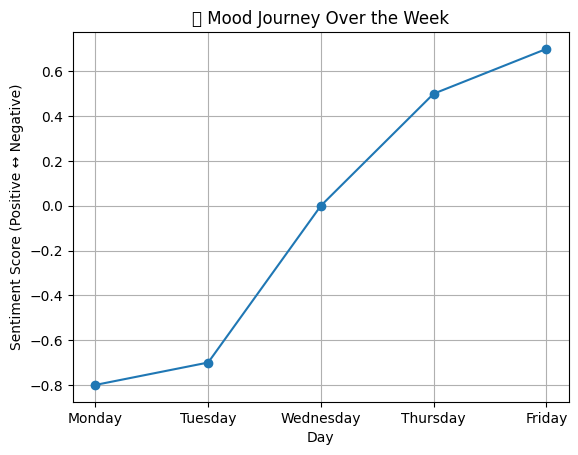

In [15]:
# Sample pseudo-data
dates = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
moods = ["stressed", "anxious", "neutral", "positive", "hopeful"]
sentiment_scores = [-0.8, -0.7, 0.0, 0.5, 0.7]

# Pseudo code to plot
import matplotlib.pyplot as plt

plt.plot(dates, sentiment_scores, marker='o')
plt.title("🧠 Mood Journey Over the Week")
plt.ylabel("Sentiment Score (Positive ↔ Negative)")
plt.xlabel("Day")
plt.grid(True)
plt.show()


# 🚀 What’s Next
- Track mood over time and visualize progress
- Let users download emotional “reflections” for therapy or self-work
- Add voice journaling 🎙️
- "Talk to me like a Coach / Therapist / Friend" toggle 🎛️


# 🤔 Limitations
- Not a replacement for therapy
- Mood classification may oversimplify emotional nuance
- Needs careful prompting to avoid toxic positivity or inappropriate advice


# 🧘 Closing Note
AI can’t heal us — but it can hold space.
That’s what Eve.ai tries to do.

# 📎Appendix

References:

[Gemini Docs](https://ai.google.dev/gemini-api/docs)

[ChromaDB](https://docs.trychroma.com/docs/overview/introduction)

[Datasets](https://www.kaggle.com/datasets)

📖 Read More

For a detailed blog about Eve.AI, the full technical breakdown, and additional insights, check out the full article here:  
👉 [Eve.AI Blog On Github](https://thesarcasticone69.github.io/gen-ai/)
